# LSTMS TEST

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)

In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [5]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

#### Part1: Forecast a univariate time series

In [24]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc2c4a52050>],
      dtype=object)

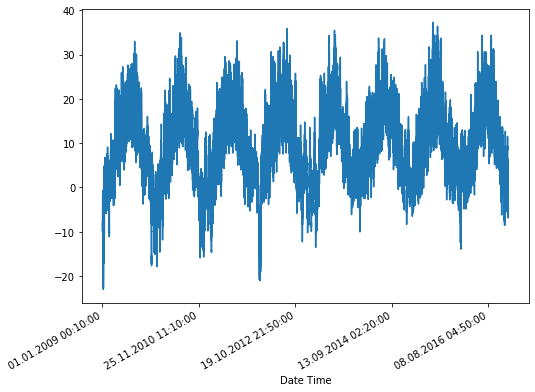

In [25]:
uni_data.plot(subplots=True)

In [26]:
uni_data = uni_data.values

In [27]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [28]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [29]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [30]:
y_val_uni.shape

(120531,)

In [53]:
def create_time_steps(length):
    return list(range(-length, 0))

In [51]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/home/usuario/.conda/envs/thesis/lib/python3.7/site-packages/matplotlib/pyplot.py'>

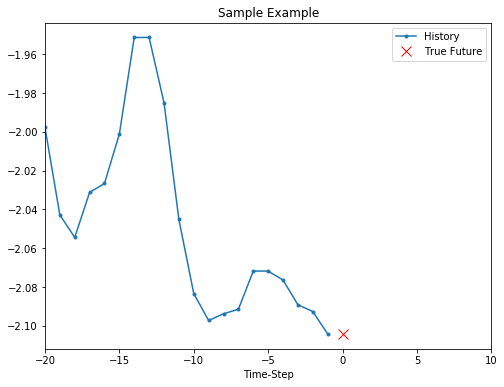

In [33]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')


In [34]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/home/usuario/.conda/envs/thesis/lib/python3.7/site-packages/matplotlib/pyplot.py'>

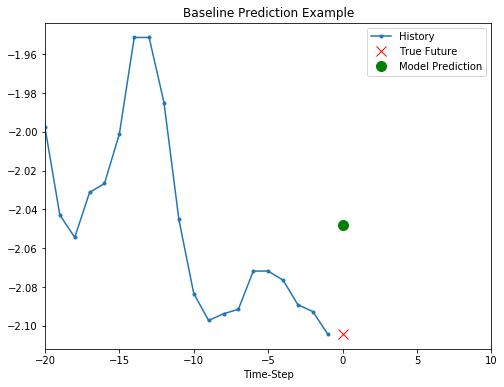

In [35]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [36]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [37]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [38]:
val_univariate.take(4)

<TakeDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>

In [22]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 12s 59ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 9s 47ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 8s 41ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 11s 53ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 11s 55ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 11s 55ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 12s 58ms/step - loss: 0.0286 - val_loss: 0.0206
Epoch 8/10
200/200 [==============================] - 11s 55ms/step - loss: 0.0263 - val_loss: 0.0196
Epoch 9/10
200/200 [==============================] - 11s 56ms/step - loss: 0.0253 - val_loss: 0.0181
Epoch 10/10
200/200 [====================

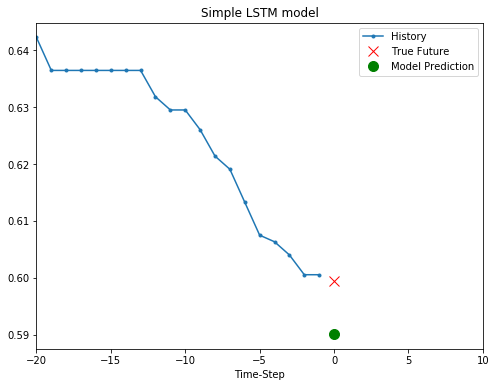

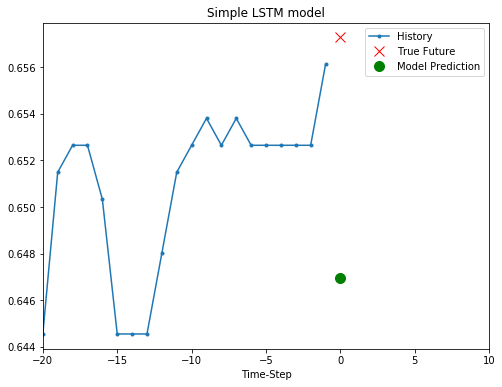

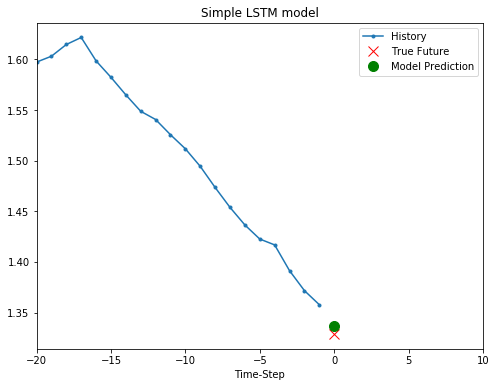

In [23]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

### Multivariate time series

In [6]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [7]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ac452e390>,
      dtype=object)

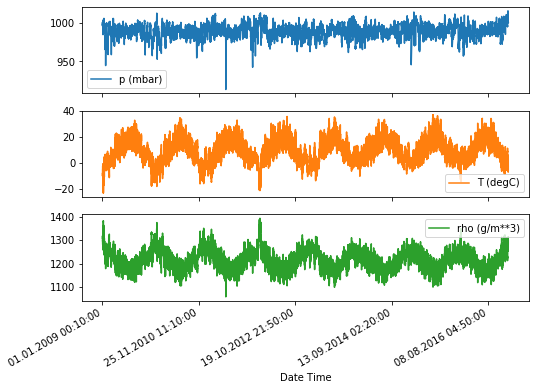

In [8]:
features.plot(subplots=True)

In [9]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [10]:
dataset = (dataset-data_mean)/data_std

In [11]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [12]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [13]:
x_train_single.shape

(299280, 120, 3)

In [14]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [15]:
# Model definition
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [16]:
train_data_single

<RepeatDataset shapes: ((None, 120, 3), (None,)), types: (tf.float64, tf.float64)>

In [18]:
EVALUATION_INTERVAL = 200
EPOCHS = 10
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
103/200 [==============>...............] - ETA: 30s - loss: 0.3761

KeyboardInterrupt: 

In [44]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

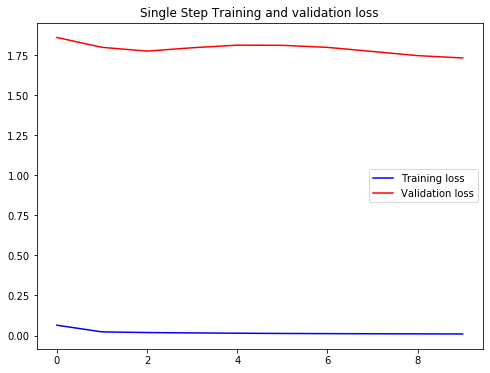

In [45]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

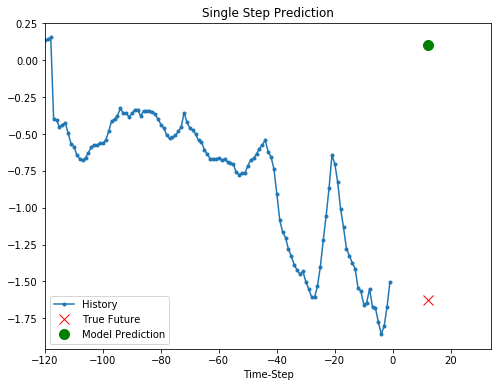

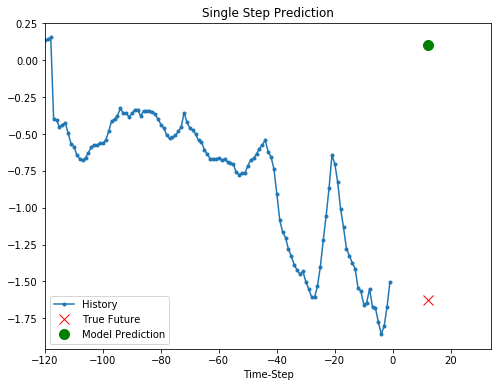

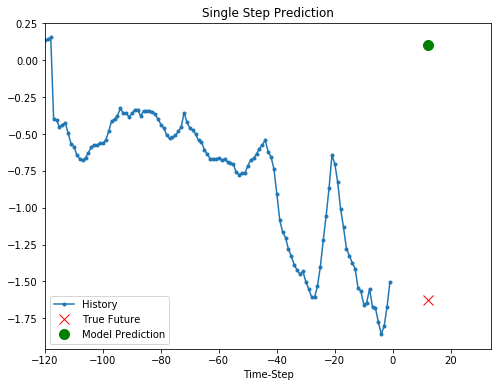

In [54]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()